In [1]:
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

In [2]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/07 19:25:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [16]:
banks_df.show()

+--------------------+---------+--------------------+--------------------+--------------------+
|     respondent_name|arid_2017|            lei_2018|            lei_2019|            lei_2020|
+--------------------+---------+--------------------+--------------------+--------------------+
| First National Bank|   110004|5493003EW6T31TGECO83|5493003EW6T31TGECO83|5493003EW6T31TGECO83|
|First Mid Bank & ...|   110045|549300XOTES5TCS8T794|549300XOTES5TCS8T794|549300XOTES5TCS8T794|
|First Hope Bank, ...|   110118|5493003XLOX5FDT9R120|5493003XLOX5FDT9R120|5493003XLOX5FDT9R120|
|First National Ba...|   110180|5493002GOGIUXB84JB89|5493002GOGIUXB84JB89|5493002GOGIUXB84JB89|
|Cumberland Valley...|   110254|549300OULGV8ZW0JV320|549300OULGV8ZW0JV320|549300OULGV8ZW0JV320|
|The Lyons Nationa...|    11027|254900Q6IHGQO7INVC79|254900Q6IHGQO7INVC79|254900Q6IHGQO7INVC79|
|Midstates Bank, N...|   110354|2549002IXACRD1HE6A92|2549002IXACRD1HE6A92|2549002IXACRD1HE6A92|
|First National Ba...|   110406|5493000L

In [17]:
banks_df.printSchema()

root
 |-- respondent_name: string (nullable = true)
 |-- arid_2017: string (nullable = true)
 |-- lei_2018: string (nullable = true)
 |-- lei_2019: string (nullable = true)
 |-- lei_2020: string (nullable = true)



In [5]:
#q1
# Read the CSV file and treat the first row as a header and infer the schema
banks_df = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv")
# Convert the DataFrame to an RDD
banks_rdd = banks_df.rdd

# Define a lambda function that checks if the word "first" is in the bank name
count = banks_rdd.filter(lambda row: "first" in row['respondent_name'].lower()).count()
count

525

In [6]:
#q2
# Define a condition that checks if the word "first" is in the bank name
condition = "LOWER(respondent_name) LIKE '%first%'"

# Use the filter transformation to get only the rows where the bank name contains "first"
filtered_df = banks_df.filter(condition)

# Use the count action to get the number of such banks
count = filtered_df.count()
count

525

In [7]:
#q3
# Save the DataFrame as a Hive table
banks_df.write.saveAsTable("banks", mode="overwrite")

# Write a SQL query to count the number of banks that include the word "first" in their name
result_df = spark.sql("SELECT COUNT(*) FROM banks WHERE LOWER(respondent_name) LIKE '%first%'")

# Convert result to int
count = result_df.collect()[0][0]
count

23/11/07 19:31:07 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/07 19:31:07 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/11/07 19:31:14 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/11/07 19:31:14 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.20.0.5
23/11/07 19:31:14 WARN ObjectStore: Failed to get database default, returning NoSuchObjectException
23/11/07 19:31:18 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
23/11/07 19:31:18 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
23/11/07 19:31:18 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/07 19:31:18 WARN 

525

In [8]:
#q4
loans_df = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs://nn:9000/hdma-wi-2021.csv")

# Save the DataFrame as a Hive table
loans_df.write.bucketBy(8, "county_code").saveAsTable("loans", mode="overwrite")

# Read other CSV files into a DataFrame and save as a Hive view
view_names = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken",
 "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]

for view_name in view_names:
    df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"hdfs://nn:9000/{view_name}.csv")
    df.createOrReplaceTempView(view_name)

# Check the tables in the warehouse
tables_df = spark.sql("SHOW TABLES")

# Convert the result to a Python dict
tables_dict = {row['tableName']: row['isTemporary'] for row in tables_df.collect()}
tables_dict

23/11/07 19:34:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [9]:
#q5
# Calculate how many loan applications a bank named "University of Wisconsin Credit Union" received in 2020
result_df = spark.sql("""
SELECT COUNT(*) 
FROM banks 
INNER JOIN loans ON banks.lei_2020 = loans.lei 
WHERE banks.respondent_name = 'University of Wisconsin Credit Union'
""")

# Convert result to int
count = result_df.collect()[0][0]
count

19739

In [10]:
#q6
result_df.explain("formatted")
#1. The table that is sent to every executor via a BroadcastExchange operation is the banks table. This is evident from the BroadcastExchange operations at steps (5) and (18) in the physical plan, where the lei_2020 column from the banks table is broadcasted.
#2. Yes, the plan does involve HashAggregates. They are present at steps (15), (12), (24), and (22) in the physical plan. These steps involve different aggregate functions. Specifically, the HashAggregate at step (15) involves the count(1) function, the HashAggregate at step (12) involves the partial_count(1) function, the HashAggregate at step (24) involves the count(1) function, and the HashAggregate at step (22) also involves the partial_count(1) function. These functions are used to count the number of rows that satisfy certain conditions in the data.

== Physical Plan ==
AdaptiveSparkPlan (25)
+- == Final Plan ==
   * HashAggregate (15)
   +- ShuffleQueryStage (14), Statistics(sizeInBytes=32.0 B, rowCount=2)
      +- Exchange (13)
         +- * HashAggregate (12)
            +- * Project (11)
               +- * BroadcastHashJoin Inner BuildLeft (10)
                  :- BroadcastQueryStage (6), Statistics(sizeInBytes=8.0 MiB, rowCount=1)
                  :  +- BroadcastExchange (5)
                  :     +- * Project (4)
                  :        +- * Filter (3)
                  :           +- * ColumnarToRow (2)
                  :              +- Scan parquet spark_catalog.default.banks (1)
                  +- * Filter (9)
                     +- * ColumnarToRow (8)
                        +- Scan parquet spark_catalog.default.loans (7)
+- == Initial Plan ==
   HashAggregate (24)
   +- Exchange (23)
      +- HashAggregate (22)
         +- Project (21)
            +- BroadcastHashJoin Inner BuildLeft (20)
               :- Br

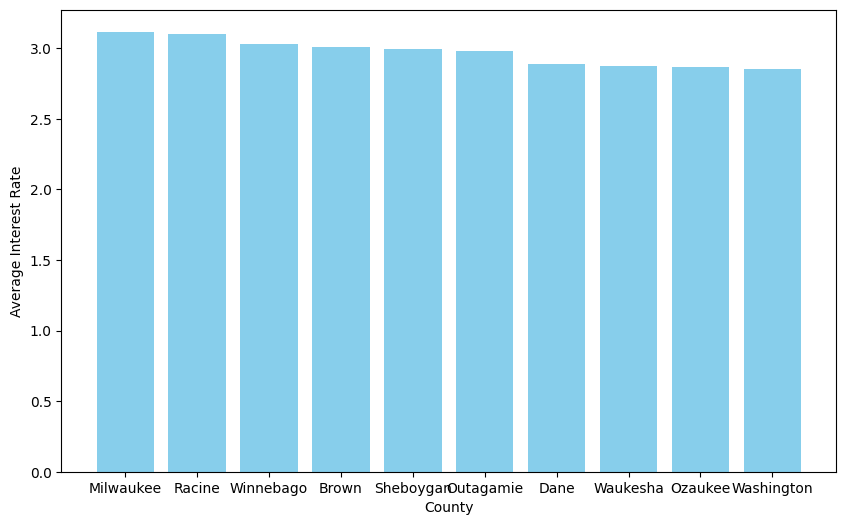

In [22]:
#q7
import matplotlib.pyplot as plt
# Use Spark SQL to calculate the average interest rate in the 10 counties where Wells Fargo received the most applications
result_df = spark.sql("""
SELECT counties.NAME, AVG(loans.interest_rate) AS avg_interest_rate
FROM banks
INNER JOIN loans ON banks.lei_2020 = loans.lei
INNER JOIN counties ON loans.county_code = counties.STATE*1000 + counties.COUNTY
WHERE banks.respondent_name = 'Wells Fargo Bank, National Association'
GROUP BY counties.NAME
ORDER BY COUNT(*) DESC
LIMIT 10
""")

# Convert the result to a Pandas DataFrame
result_pd = result_df.toPandas()

# Sort the DataFrame by the number of applications
result_pd = result_pd.sort_values(by='avg_interest_rate', ascending=False)

# Display the average interest rate in a bar chart
plt.figure(figsize=(10, 6))
plt.bar(result_pd['NAME'], result_pd['avg_interest_rate'], color='skyblue')
plt.ylabel('Average Interest Rate')
plt.xlabel('County')
plt.show()


In [23]:
#q8
# Calculate the average interest rate by grouping by county_code
result_df = spark.sql("""
SELECT county_code, AVG(interest_rate) AS avg_interest_rate
FROM loans
GROUP BY county_code
""")
result_df.explain()

# Calculate the average interest rate by grouping by LEI
result_df = spark.sql("""
SELECT lei, AVG(interest_rate) AS avg_interest_rate
FROM loans
GROUP BY lei
""")
result_df.explain()


# When computing a MEAN aggregate per group of loans, network I/O is required between the partial_mean and mean operations when the cardinality (number of unique values) of the group is high. 
# This is because Spark needs to shuffle the data across the network to ensure all rows of the same group are on the same node for computation. 
# In this case, grouping by 'lei' requires network I/O because 'lei' has higher cardinality than 'county_code'. 
# However, when grouping by 'county_code', network I/O is not required because the data was bucketed by 'county_code' when it was loaded into the Hive table.

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[county_code#783], functions=[avg(cast(interest_rate#802 as double))])
   +- HashAggregate(keys=[county_code#783], functions=[partial_avg(cast(interest_rate#802 as double))])
      +- FileScan parquet spark_catalog.default.loans[county_code#783,interest_rate#802] Batched: true, Bucketed: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://nn:9000/user/hive/warehouse/loans], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<county_code:string,interest_rate:string>, SelectedBucketsCount: 8 out of 8


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[lei#780], functions=[avg(cast(interest_rate#802 as double))])
   +- Exchange hashpartitioning(lei#780, 200), ENSURE_REQUIREMENTS, [plan_id=2097]
      +- HashAggregate(keys=[lei#780], functions=[partial_avg(cast(interest_rate#802 as double))])
         +- FileScan parquet spark_catalog.default.lo

In [26]:
distinct_actions_df = spark.sql("""
SELECT DISTINCT action_taken
FROM loans
""")
distinct_actions_df.show()

+------------+
|action_taken|
+------------+
|           1|
|           6|
|           3|
|           5|
|           4|
|           8|
|           7|
|           2|
+------------+



In [27]:
#q9
from pyspark.sql.functions import when, col

# Create a new DataFrame df with the attributes and labels
df = spark.sql("""
SELECT loan_amount, income, interest_rate,
       CASE WHEN action_taken = '1' THEN 1.0 ELSE 0.0 END AS approval
FROM loans
""")

# Convert the approval, income, and interest_rate columns to double type, and fill the missing values with 0.0
df = df.withColumn("approval", col("approval").cast("double"))
df = df.withColumn("income", col("income").cast("double"))
df = df.withColumn("interest_rate", col("interest_rate").cast("double"))
df = df.na.fill(0.0)

# Split the DF into a training set and a test set
train, test = df.randomSplit([0.8, 0.2], seed=41)

# Cache the training DataFrame
train.cache()

# Count the number of approved loans in the training DataFrame
num_approved_loans = train.filter(col("approval") == 1.0).count()
num_approved_loans


242868

In [28]:
#q10
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Combine the attribute columns to create a single vector column
assembler = VectorAssembler(
    inputCols=["loan_amount", "income", "interest_rate"],
    outputCol="features"
)
train = assembler.transform(train)
test = assembler.transform(test)

# Train a decision tree classifier with a depth of 5
dt = DecisionTreeClassifier(labelCol="approval", featuresCol="features", maxDepth=5)
model = dt.fit(train)

# Perform a prediction on the test data
predictions = model.transform(test)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="approval", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
accuracy


0.8929195560947918